# 15-688 Final Project Report 



## 0. Background

Social media has become a new way of communication. It has revolutionized the relationship between users and digital products. The social media users are not only consumers, they are also content creators, providers and spreaders. A massive amount of data has been generated directly by users and this allows us to measure people’s attention and attitude regarding a product in large scale. 

Can the social media activities reflect our behaviors in real life?  Previous research showed that the tweets in a critical time period can successfully predict real world outcomes. A study on movie showed that both tweet - rate (number of tweets per hour) and sentiments of tweets could predict the box-office revenue (Asur, 2010) and the rating  of a particular movie (Oghina,2012). Also, some other studies demonstrated that the overall attitude of tweets has high correlation with people’s behavior in the stock market (Bollen,2011), political elections (Bermingham,2011), and etc.,

It might go beyond our expectations in the ways how these social media indicators are correlated with the real world outcomes. For example, products (De Vries,2012) and movies (e.g., [Tiny Times](https://en.wikipedia.org/wiki/Tiny_Times)) that have received negative comments were even more popular than those who received relatively higher ratings in social media. 

In this project, we use movie's box office as our subject area and try to find its correlation Twitterw :
- This subject area has research basis, which is both a good foundation of our project and a credible resource for comparing the project results.
- The real world outcomes (purchase behavior) can be easily measured by the box-office revenue.
- The “quality” of a product can be indicated by the IMDb score.




In [105]:
import pickle
import numpy as np
import pandas as pd
import datetime
import unirest
import nltk
import sklearn
import string
import csv
import ast
from pytagcloud import create_tag_image, make_tags
from pytagcloud.lang.counter import get_tag_counts
from sklearn.decomposition import TruncatedSVD
from pattern.en import sentiment, parsetree
from glob import glob
from collections import Counter
from get_tweets import get_tweets
from text_classification import process_all, get_rare_words, create_features
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import matplotlib
matplotlib.use("svg")
import matplotlib.pyplot as plt
plt.style.use("ggplot")


/Users/weijian/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## 1. Data-preparation & analysis

### 1.1. Movie Box Office Data  
   
   In the data preparation section, the first step of the project is to grasp movie data and twitter data separately:
For the movie data part, the main information we care about here are: movie’s name, total domestic box office amount (we narrow down the research area for only focusing on North America region), movie’s release date, genre, and distributors. The first two features are the main identifiers for the movie marked as our label. The third feature (release date) is used for targeting a specific time range for tweets search, and the rest of the features can be used for movie classification since we assume that correlations between twitter and a movie’s box office may also depends on movie’s type.

During the searching for box office data, we found that most of the movie box office information is either not complete or not freely available. To our best knowledge, there is no public and free API available for large scale movie box office query service. Therefore, we decide to write web scrapper by ourselves to collect box office data from [Boxoffice-Mojo](www.boxofficemojo.com). Boxoffice-Mojo is a website that tracks box office for more than 16,000 movies. 

Basically, we use [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/) and python [urllib2](https://docs.python.org/2/library/urllib2.html) library  to do web data scrapping and saved the data into ‘movies_data.pkl’ file. 

In the following code, movie data is imported and sorted by its domestic total gross in decreasing order. The top 5 ranking movies are shown below:


In [37]:
#load movie data from scrapper file
with open('movies_data.pkl', 'r') as picklefile:
    movies_scraped, movies_skipped = pickle.load(picklefile)

In [93]:
movies = pd.DataFrame(movies_scraped)
movies.dropna(axis=0, subset=['domestic_total_gross'], inplace=True)
movies.sort_values(by='domestic_total_gross', ascending=False, inplace=True)
print len(movies)
movies.head()

14682


,BOM_id,actors,budget,director,distributor,domestic_total_gross,genre,movie_title,opening_income_wend,opening_theaters,rating,release_date,runtime_mins
9982,starwars7,John BoyegaDaisy RidleyAdam DriverOscar IsaacA...,245000000.0,J.J. Abrams,Buena Vista,936662225.0,Sci-Fi Fantasy,Star Wars: The Force Awakens,247966675.0,4134.0,PG-13,2015-12-18,136.0
13275,avatar,Sam WorthingtonZoe SaldanaSigourney WeaverMich...,NaN,James Cameron,Fox,749766139.0,Sci-Fi Adventure,Avatar,77025481.0,3452.0,PG-13,2009-12-18,160.0
1772,jurassicpark4,Nick RobinsonOmar SyChris PrattBryce Dallas Ho...,150000000.0,Colin Trevorrow,Universal,652270625.0,Action / Adventure,Jurassic World,208806270.0,4274.0,PG-13,2015-06-12,124.0
2616,avengers11,"Robert Downey, Jr.Chris HemsworthChris EvansJe...",220000000.0,Joss Whedon,Buena Vista,623357910.0,Action / Adventure,Marvel's The Avengers,207438708.0,4349.0,PG-13,2012-05-04,142.0
7211,titanic,Leonardo DiCaprioKate WinsletBilly ZaneKathy B...,200000000.0,James Cameron,Paramount,600788188.0,Romance,Titanic,28638131.0,2674.0,PG-13,1997-12-19,194.0


We can see that 14,682 movies’ information is dumped from the website and we checked our data by sorting their domestic total box office in descending order. We can see that the top 5 movies are:
* Star War VII        : 936,662,225 
* Avatar              : 749,766,139
* Jurassic Park IV    : 652,270,625
* Avengers II         : 623,357,910
* Titanic             : 600,788,188

It is already verified by other resource which means our data is reliable.
Here is the genre information for the collected movies and their counting distribution:

We can find out that the overall most frequent movies in the industry is not exactly as we expected. There are 2065 movies labeled as 'Unknown'. We think that this is because some of the old films (before 1980s) are hard to classified with type creteria nowadays. Besides, the top three types of movies are 'Foreign' (1671 movies), 'Drama' (1524 movies) and 'Documentary' (1512 movies).

In [89]:
print movies['genre'].unique()
print movies['genre'].value_counts().head(10)
print movies['genre'].value_counts()['Unknown']

[u'Sci-Fi Fantasy' u'Sci-Fi Adventure' u'Action / Adventure' u'Romance'
 u'Animation' u'Action Thriller' u'Period Adventure' u'Sci-Fi Action'
 u'Fantasy' u'Historical Drama' u'Adventure' u'Action' u'Family Adventure'
 u'Sci-Fi Horror' u'Drama' u'Comedy / Drama' u'Horror' u'Family Comedy'
 u'Comedy' u'Sci-Fi Thriller' u'Horror Thriller' u'Sports Drama'
 u'Sci-Fi Comedy' u'Fantasy Comedy' u'Action Drama' u'Romantic Comedy'
 u'Action Comedy' u'Horror Comedy' u'Sci-Fi' u'Fantasy Drama' u'Thriller'
 u'War' u'Period Action' u'Action Horror' u'Historical Epic' u'Western'
 u'Crime Comedy' u'Adventure Comedy' u'Period Drama' u'Musical'
 u'Sports Comedy' u'Drama / Thriller' u'Crime Drama' u'Foreign / Action'
 u'Period Horror' u'Music Drama' u'Western Comedy' u'Documentary'
 u'War Drama' u'Sports Action' u'Period Comedy' u'Crime' u'Action / Crime'
 u'War Romance' u'IMAX' u'Action Fantasy' u'Crime Thriller'
 u'Romantic Thriller' u'Comedy Thriller' u'Family' u'Romantic Adventure'
 u'Concert' u'Fore

Another thing we need to point out is that, since we are interested with the correlation between a movie's box office and its tweets features. It is obvious that we only care about movies released after Twitter becoming popular. In this case, we filtered out all movies released before 2008 and left with 5278 movies. In the rest part of the report, we will only focus on movies data that released after 2008.

The most important difference between these two distribution we can observe is that, the popularity of Action moive raises after 2008 as we can see from the result below:

In [90]:
#get new movies after 20008
new_movies = movies.loc[movies['release_date'] >= np.datetime64('2008-01-01')]
print len(new_movies)
print 
print new_movies['genre'].value_counts().head(10)


5642

Documentary        987
Drama              935
Foreign            883
Comedy             547
Comedy / Drama     234
Thriller           211
Animation          191
Horror             171
Romantic Comedy    112
Action             100
Name: genre, dtype: int64


### 1.2. Twitter comments data
  
When collecting twitter data, we also met some challenges. Our task is to collect tweets related to a specific film during the time period of the film release (The fact is that different movies may have different time period of release length, but here we assume every movie will be released for 45 days for simplicity). When we say ‘related to a film’, we use 'OR' operator to concatenate movie's name and id as keywords and hashtags to generate a query to search for one tweet. 


At first we tried using keywords directly but it turned out that we have so many unrelated tweets returned as results. The precision for our sample is extremely low using this way. Therefore instead, if one tweet contains a film’s name or hash-tag, we regard this tweet as related to this film. 

Unfortunately, Twitter [streaming API](https://dev.twitter.com/streaming/overview) only allows us to fetch the latest tweets within a week when given keywords and hashtag. Therefore, most of the films’ related tweets which posted earlier than a week cannot be fetched. We also tried several reliable open-sourced twitter data fetching library, since most of them are based on Twitter streaming API so they cannot satisfy our requirement either. One of a not-very-popular library is found [here](https://github.com/Jefferson-Henrique/GetOldTweets-python). The basic idea is that when you enter on Twitter page a scroll loader starts, if you scroll down you start to get more and more tweets, all through calls to a JSON provider. After mimic we get the best advantage of Twitter Search on browsers, it can search the deepest oldest tweets. The good thing is that this library can fit most of our requirement, and the bad thing is that it is not a very reliable library due to its popularity. (As you can see we have to throw out some bad quality data and handle error by choosing this library in the following sessions).
 
Blocks below are codes we used to collect tweets data. Temporarily, we set the max tweets number for each movie to be 1,000. We will adjust this number in the future if the training/testing performance does not go well. Basic features we used for each tweet are its word count, retweet number, and whether it contains links. Besides, we conduct sentimental analysis from a [public API](http://text-processing.com/api/sentiment/). 

Due to the daily usage limitation for sentimental analysis API, we only choose seven films to do the sentimental analysis here, among the seven movies, four of them are popular movies which have very high box office, while the other three are relatively normal movies:


In [11]:
time_range = datetime.timedelta(days=60)
maxtweets = 1000

def fetch_tweets(row):
    BOM_id = row['BOM_id']
    movie_title = row['movie_title']
    query = BOM_id + ' OR #' + BOM_id + ' OR ' + movie_title + ' OR #' + movie_title
    date = row['release_date']
    start = date.date().strftime('%Y-%m-%d')
    end = (date.date() + time_range).strftime('%Y-%m-%d')
    get_tweets(filename='data2/' + BOM_id, maxtweets=maxtweets, query=query, since=start, until=end)
    print movie_title, start, end

In [ ]:
# used for featching tweets, do not need to run it for testing, see below section 3 for instruction detail
# for _, row in new_movies.iterrows():
#     fetch_tweets(row)

In [13]:
#small samples for tweets sentiment feature
fetched_movie = {}
directories = glob('data/*')
print directories
for directory in directories:
    BOM_id = directory[5:]
    print BOM_id
    fetched_movie[BOM_id] = pd.read_csv(directory, sep=';', index_col=0)

['data/avatar', 'data/avengers11', 'data/jurassicpark4', 'data/misterlonely', 'data/starwars7', 'data/totalrecall2012rerelease', 'data/womenintrouble']
avatar
avengers11
jurassicpark4
misterlonely
starwars7
totalrecall2012rerelease
womenintrouble


In [14]:
def sentiment(text):
    # response = requests.post('http://text-processing.com/api/sentiment/', data={'text': text})
    response = unirest.post("https://japerk-text-processing.p.mashape.com/sentiment/",
        headers={
            "X-Mashape-Key": "EMrBfg9GO4mshgbevq2BtBZCdet3p1iXIWejsnKRDuWRNljYxI",
            "Content-Type": "application/x-www-form-urlencoded",
            "Accept": "application/json"
          },
        params={
            "language": "english",
            "text": text
          }
    )
    if response.code != 200:
        print response.code
        print response.body
        print 'failed: {}'.format(text)
        return {'sentiment': None, 'probability': None}
    sentiment = response.body['label']
    if sentiment == 'pos':
        return {'sentiment': 1, 'probability': response.body['probability']}
    elif sentiment == 'neg':
        return {'sentiment': -1, 'probability': response.body['probability']}
    else:
        return {'sentiment': 0, 'probability': response.body['probability']}

In [15]:
def get_sentiments(movie_dict):
    for BOM_id, movie in movie_dict.items():
        sentiments = pd.DataFrame([sentiment(text) for text in movie['text']])
        movie_dict[BOM_id] = pd.concat([movie, sentiments], axis=1)
        #movie.to_csv('data/' + BOM_id, sep=';')
        print BOM_id

In [16]:
def ouput_csv(movie_dict):
    for BOM_id, movie in movie_dict.items():
        movie.to_csv('data/' + BOM_id, sep=';')

From the following result we can see that, '1.0' represents a posive tweet, '-1.0' represents a negative tweet while '0.0' represents a neutral tweet. According to the sample we collected, popular movies tend to have more positive reviews and more tweets and retweets amount as a whole.
More detailed research and their correlation will be studied in the next section.

In [17]:
for title, movie in fetched_movie.items():
    counter = Counter(movie['sentiment'])
    print title, " : ", counter, 'total: ', sum(counter.values())

starwars7  :  Counter({0.0: 650, 1.0: 335, -1.0: 11, nan: 1, nan: 1}) total:  998
avengers11  :  Counter({1: 777, 0: 183, -1: 39}) total:  999
womenintrouble  :  Counter({0: 370, 1: 192, -1: 113}) total:  675
misterlonely  :  Counter({0: 16, 1: 16, -1: 6}) total:  38
totalrecall2012rerelease  :  Counter({-1: 635, 1: 253, 0: 111}) total:  999
avatar  :  Counter({1: 467, 0: 287, -1: 246}) total:  1000
jurassicpark4  :  Counter({0: 481, 1: 334, -1: 185}) total:  1000


## 2. Data Visualization

The first step towards a successful ML model is understanding what's in the dataset. By using basic statistic metholody and data visualization, we could easily achieve that.  Since there are so many fileds in the movie dataset, throw everything together into the machinel learning blackbox is definitely not a good idea, therefore, we need to study these fields one by one to get some idea about whether they could be useful or not.

In [95]:
with open('movies_tweets_combined.pkl', 'r') as picklefile:
    movies_tweets_combined = pickle.load(picklefile)
    
with open('movies_after_2008_tweets.pkl', 'r') as picklefile:
    tweets = pickle.load(picklefile)    

In [98]:
movies = pd.DataFrame(movies_scraped)
movies.dropna(axis=0, subset=['domestic_total_gross'], inplace=True)
movies.sort_values(by='domestic_total_gross', ascending=True, inplace=True)
movies = movies.set_index('BOM_id')
all_movies = movies.loc[movies_tweets_combined['name']]
all_movies.sort_values(by='domestic_total_gross', ascending=True, inplace=True)

### 2.1.Diversity
The first thing we want to explore is the diversity of tweets.
This includes:
1. Are the tweets from a few users or widely spread users?
2. Are the tweets from a few locations or globally?

we define the diversity of users as the ratio of
\begin{equation*}
\frac{NumofUniqueUsers}{NumOfTweets}
\end{equation*}.

Similarly, the diversity of locations as the ratio of 

\begin{equation*}
\frac{NumofUniqueLocations}{NumOfTweets}
\end{equation*}.


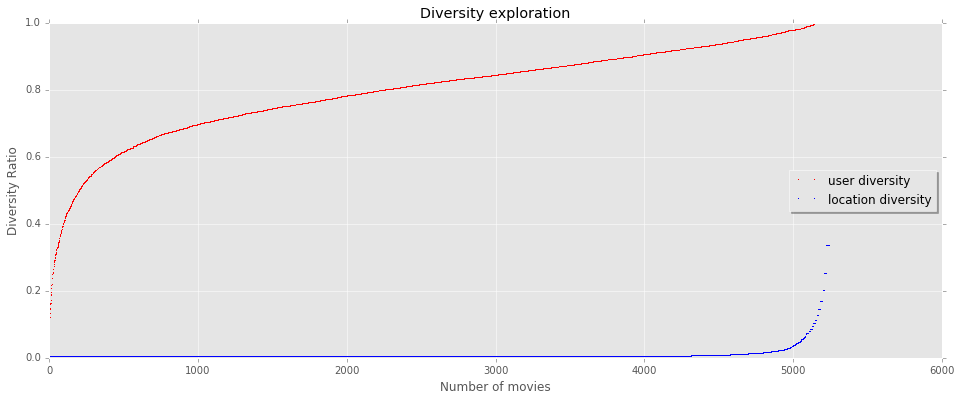

In [99]:
def diversity_user(df):
    return float(df['"username'].unique().shape[0]) / df.shape[0]
    
def diversity_location(df):    
    return float(df['geo'].unique().shape[0]) / df.shape[0]

diversity_users = np.array([diversity_user(tweets[BOM_id]) for BOM_id in all_movies.index])
diversity_locations = np.array([diversity_location(tweets[BOM_id]) for BOM_id in all_movies.index])

# N = len(diversity_users)
# Plot outputs
diversity_users.sort()
diversity_locations.sort()
fig, ax = plt.subplots()
ax.plot(diversity_users, 'r,', label='user diversity')
ax.plot(diversity_locations, 'b,', label='location diversity')
plt.xlabel('Number of movies')
plt.ylabel('Diversity Ratio')
plt.title(r'Diversity Exploration')

legend = ax.legend(loc='center right', shadow=True)
plt.show()

The figure above gives us a visible understanding of our dataset:
1. the posts for each movie are generally from a pretty widely spread user base
2. However, the geo locations are pretty centralized. After a close investigation, it turns out for most of the tweets, there are actually no geo infomation at all. This indicates that the data quality of geo is pretty bad and we should not consider use it for training.

Then we have to ask, would the tweets diversity has something to do with the box office gross of that movie?
The following image can explain this.

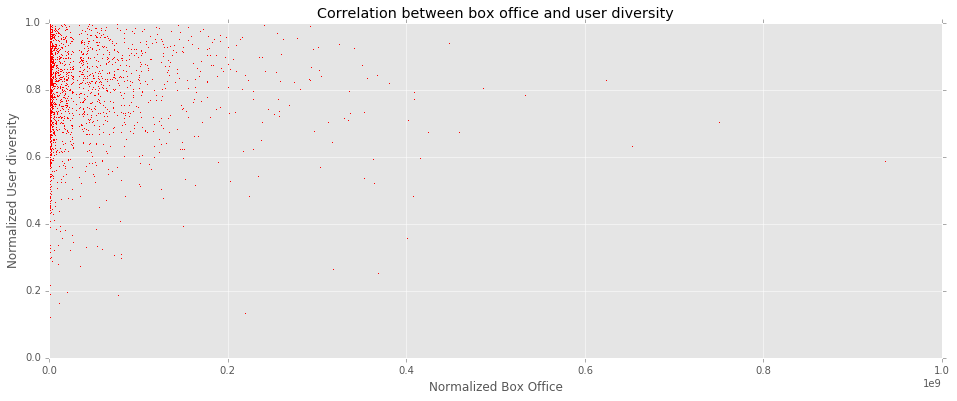

In [110]:
diversity_users = np.array([diversity_user(tweets[BOM_id]) for BOM_id in all_movies.index])
plt.plot(all_movies['domestic_total_gross'], diversity_users, 'r,')
plt.xlabel('Normalized Box Office')
plt.ylabel('Normalized User diversity')
plt.title(r'Correlation between box office and user diversity')

plt.show()

You can see that for those few high gross movies, there user diversities are pretty good, but just as good as the remaining. so we can hardly relate user diversity with movie gross.

### 2.2. Sparsity

We notices that in the dataset, there are some othere fields that maybe useful. These fields include `retweets`, `favorites`, `mentions`, `hashtags` and of course `geo`. we want to know if these fields have something to do with the box office gross.

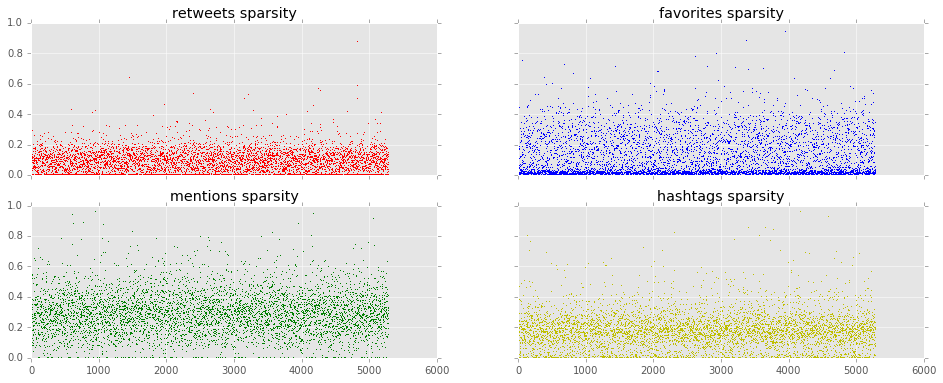

In [108]:
def sparsity_int(s):
    return np.sum(s != 0) / float(len(s))

def sparsity_str(s):
    return np.sum(s.apply(lambda x: type(x) != float)) / float(len(s))

sparsity_retweets = np.array([sparsity_int(tweets[BOM_id]['retweets']) for BOM_id in all_movies.index])
sparsity_favorites = np.array([sparsity_int(tweets[BOM_id]['favorites']) for BOM_id in all_movies.index])
sparsity_mentions = np.array([sparsity_str(tweets[BOM_id]['mentions']) for BOM_id in all_movies.index])
sparsity_hashtags = np.array([sparsity_str(tweets[BOM_id]['hashtags']) for BOM_id in all_movies.index])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
ax1.plot(sparsity_retweets, 'r,', label='retweets sparsity')
ax1.set_title('retweets sparsity')
ax2.plot(sparsity_favorites, 'b,', label='favorites sparsity')
ax2.set_title('favorites sparsity')

ax3.plot(sparsity_mentions, 'g,', label='mentions sparsity')
ax3.set_title('mentions sparsity')

ax4.plot(sparsity_hashtags, 'y,', label='hashtags sparsity')
ax4.set_title('hashtags sparsity')

plt.show()

Sadly the results are pretty much the same as `geo`. Most of these fields are very sparse. and these aren't any very strong correlation between these fields and the box office gross. 

However, during the calculation, we found following interesting plot. it shows that the more people mentions others in their posts about centain movie, the bigger chance that movie could have more gorss. We'll see if we can levarage this in our training phase

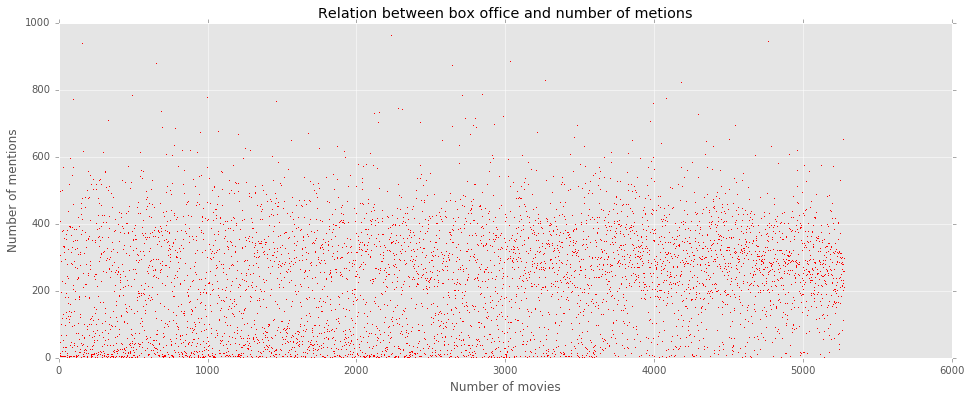

In [111]:
count_mentions = np.array([np.sum(tweets[BOM_id]['mentions'].apply(lambda x: type(x) != float)) for BOM_id in all_movies.index])
plt.plot(count_mentions, 'r,')
plt.xlabel('Number of movies')
plt.ylabel('Number of mentions')
plt.title(r'Relation between box office and number of metions')

plt.show()
                           

### 2.3. Tag Cloud
An interesting visualization is tag cloud. It's pretty popular around the social network nowadays. You probably already saw many of them. Here we could use the `pytagcloud` to easily create our own tag cloud. Let's build one for the best selling movie and one for the worst. 

In [103]:
# print movies_tweets_combined.head()
aggregated_tweets = movies_tweets_combined.set_index('name')
all_movies = movies.loc[movies_tweets_combined['name']]

In [106]:
best_movie = all_movies.loc[all_movies['domestic_total_gross'].idxmax()]
worst_movie = all_movies.loc[all_movies['domestic_total_gross'].idxmin()]

tags = make_tags(get_tag_counts(aggregated_tweets.loc[best_movie.name].text)[:60], maxsize=120)
create_tag_image(tags, 'best_movie.png', size=(600, 300), background=(0, 0, 0, 255), fontname='Lobster')

tags = make_tags(get_tag_counts(aggregated_tweets.loc[worst_movie.name].text)[:60], maxsize=120)
create_tag_image(tags, 'worst_movie.png', size=(600, 300), background=(0, 0, 0, 255), fontname='Lobster')

The following two images is the tag cloud we created.
<img src="best_movie.png">
<h4 align="center">Cloud tag for best movies</h4> 
<img src="worst_movie.png">
<h4 align="center">Cloud tag for worst movies</h4> 
From the above tag cloud, we could observe that :
1. see that some common words are everywhere. These words are generally something like 'twitter', 'http', 'com', 'www' that actually belongs to the link of a tweet. 
2. Movie name is another popular tag but may actually meaningless for our training purpose
3. There are some words like 'million', 'billion' that seems to be interesting. 

In the trining section, we should see if we could make use of all the observations above.

### 2.4. Sentiment
It's hard to get meaningful data from raw tweets. However, it's intuitive to assume that box office has something to do with at least user sentiment.

In the following section, we first calculate the sentiment of each tweet and then visualize it's relation againt box office.

In [ ]:
sentiments = np.array([np.mean(tweets[BOM_id]['text'].apply(lambda x: sentiment(x)[0])) for BOM_id in all_movies.index])
with open('sentiments.pkl', 'w') as picklefile:
    pickle.dump(sentiments, picklefile, protocol=pickle.HIGHEST_PROTOCOL)

In [112]:
with open('sentiments.pkl', 'r') as picklefile:
    sentiments = pickle.load(picklefile)

From the following plot we can find out that, the movies which have highest box office do not have the highest sentiment score. It makes sense since the most 'popular' movie must have a group of people discussing it, including both positive and negative voices. 

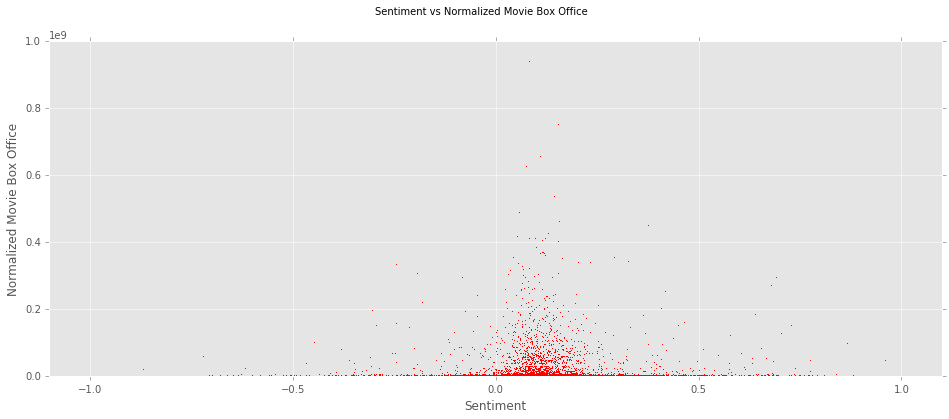

In [119]:
plt.suptitle('Sentiment vs Normalized Movie Box Office')
plt.xlabel('Sentiment')
plt.ylabel('Normalized Movie Box Office')
plt.xlim(-1.1, 1.1)
plt.plot(sentiments, all_movies['domestic_total_gross'], 'r,')
plt.show()

## 3. Feature Extraction

After playing with small data-set on movie's box office, we are moving on to the full data set of movies. Since the whole tweets data and movie data is larger than 1 GB, it is not realistic to re-run everything we do for all the code blocks we list below. Therefore, just for convenience, we provide a quicker version for you, using [Pickle](https://docs.python.org/2/library/pickle.html) to dump all the results file which takes long to run(more than several hours), and you can simply load these files into the notebook in order to catch up with our code and save a lot of time.


In [19]:
with open('movies_clean_tweets_combined.pkl', 'r') as picklefile:
     movies_clean_tweets_combined = pickle.load(picklefile)
with open('movies_clean_features.pkl', 'r') as picklefile:
    clean_features = pickle.load(picklefile)
with open('movies_after_2008_tweets.pkl', 'r') as picklefile:
    movies_after_2008 = pickle.load(picklefile)
with open('movies_features.pkl', 'r') as picklefile:
    ori_features = pickle.load(picklefile)


We are now try to extract features from the raw text of tweets. The most simple feature would be just the word count of each tweet. Two sophisticated features for text documents would be the token count matrix, which counts the frequency of each word in each tweet, and the [frequency–inverse document frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) (IF-TDF) matrix, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. Also, as mentioned above, the sentiment value of each tweet may also be a useful feature.

Notice that we have about 1000 tweets per movie, which means the feature space of each movie will likely be very large while domestic gross income is just one value. To prevent overfitting, we need to reduce the feature space. 

### 3.1. General Idea: Extract features from raw text but also try to reduce feature space.
1. Tokenize and lemmatize each tweet.
2. Reduce feature space.
3. Create word count, DF-IDF, sentiment, and length features.

Here are a few method we have thought about.

### 3.2. Pre feature extraction: 
1. create a parse tree for each tweet and only keep nouns, verbs and adjectives, which seems to contain most of the information of a tweet. However, this method is too computational expansive as we have tried for hours and got no results.
2. just pick the top $n$ of the most frequent words in the whole corpus and extract features only from those words.
3. combine all tweets corresponding to each movie into a single long text.

### 3.3. Post  feature extraction:
1. Use dimension reduction methods on the feature matrix. A common method used in natural language processing is [latent semantics analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis)(LSA) which is basically the used of [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) on the token count matrix. We tried this with the feature matrix from the original tweets, but with 1000 components produced the ration of variance explained is only 0.02.

### 3.4. On response variable:
1. Add Gaussian noise to domestic gross income to create more data points for each movie. This method was come up when we planned to analyze only on 50 ~ 100 movies, but now we have 5000+ data points, so it seems unnecessay.

After several trials, the final choice is combine all tweets of each movie and pick the top $n$ words in the whole corpus and extract features.

In [92]:
directories = glob('data2/*')

In [ ]:
movies_after_2008 = {}
for directory in directories:
    try:
        movies_after_2008[directory.rsplit('/',1)[1]] = pd.read_csv(directory, sep='","', engine='python', quoting=csv.QUOTE_ALL)
    except:
        print "something wrong with"+directory
with open('movies_after_2008_tweets.pkl', 'w') as picklefile:
    pickle.dump(movies_after_2008, picklefile, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
def clean(text):
    _text = text.lower()
    for char in string.punctuation:
        _text = _text.replace(char, " ")
    return _text

# create features for the 'text' column in df
def get_features(df):
#     trees = [parsetree(clean(text), lemmata=True)[0] for text in df['text']]
#     processed_tweets = df.assign(text=[
#         [word.lemma for word in tree if word.tag.startswith(('JJ', 'NN', 'VB', '!'))] # only keep verbs, noun, adjective
#         for tree in trees
#     ])
    processed_tweets = df
    rare_words = get_rare_words(processed_tweets) # get rare words
    lengths = [len(tweet) for tweet in processed_tweets['text']] # get length of words remaining
    sentiments = [sentiment(tweet)[0] for tweet in processed_tweets['text']] # get sentiment -1.0 ~ 1.0
    # create TfidfVectorizer, CountVectorizer and corresponding feature matrix
    tfidf, X_tfidf, count, X_count = create_features(processed_tweets, rare_words) 
    return tfidf, X_tfidf, count, X_count, lengths, sentiments

# combine multiple data frames into one by combining all texts in a data frame into one string
def combine_df(dfs):
    X = pd.DataFrame()
    text = []
    names = []
    for df_key in dfs:
        text.append(clean(' '.join(dfs[df_key]['text'])))
        names.append(df_key)
    X['name'] = names
    return X.assign(text=text)

def get_topn_words(processed_tweets,n):
    counter = Counter()
    for _, row in processed_tweets.iterrows():
        counter.update(row['text'])
    return counter

In [ ]:
combined_df = combine_df(movies_after_2008)
combined_df.to_pickle("movies_tweets_combined.pkl")
tknzr = TweetTokenizer()
counter = Counter()
tmp = []
for _,row in combined_df.iterrows():
    tmp.append([ word for word in tknzr.tokenize(row['text']) if word not in stopwords.words('english')])
combined_df['text'] = tmp
with open('movies_clean_tweets_combined.pkl', 'w') as picklefile:
    pickle.dump(combined_df, picklefile)


In [ ]:
topn_words =  get_topn_words(movies_clean_tweets_combined,500)
clean_features = get_features(movies_clean_tweets_combined)
with open('movies_clean_features.pkl', 'w') as picklefile:
    pickle.dump(clean_features, picklefile)


In [22]:
tfidf = clean_features[1].todense()
count = clean_features[3].todense()
ori_length = ori_features[4]
ori_sentiments = ori_features[5]

clean_length = clean_features[4]
clean_sentiments = clean_features[5]

max_ori_length = max(ori_length)*1.0
ori_normal_length = [item/max_ori_length for item in ori_length]
max_clean_length = max(clean_length)*1.0
clean_normal_length = [item/max_clean_length for item in clean_length]

feature_matrix = np.append(tfidf, np.array(ori_normal_length).reshape(5278,1), 1)
feature_matrix = np.append(feature_matrix, np.array(ori_sentiments).reshape(5278,1), 1)
feature_matrix = np.append(feature_matrix, np.array(clean_normal_length).reshape(5278,1), 1)
feature_matrix = np.append(feature_matrix, np.array(clean_sentiments).reshape(5278,1), 1)

feature_matrix1 = np.append(count, np.array(ori_normal_length).reshape(5278,1), 1)
feature_matrix1 = np.append(feature_matrix1, np.array(ori_sentiments).reshape(5278,1), 1)
feature_matrix1 = np.append(feature_matrix1, np.array(clean_normal_length).reshape(5278,1), 1)
feature_matrix1 = np.append(feature_matrix1, np.array(clean_sentiments).reshape(5278,1), 1)

print feature_matrix.shape
print feature_matrix1.shape

(5278, 479)
(5278, 479)


## 4. Prediction

### 4.1.  Value Prediction
  For the machine learning training&predicting session, we first regard the problem as a real-value prediction problem. Given the training data size and formoat, we decide to first use Linear regression for trial. The advantage of using linear regression are basically these two:
  1. stable with optimized solution
  2. fast to calculate , easy to implement and run
  
It turns out that the performance of linear regression method is very acceprtable. From the code results below (in the final blcok), we can see that when define the "Relative Estimate Error" as :
\begin{equation*}
\frac{|RealBoxOffice-PredictBoxOffice|}{RealBoxOffice}
\end{equation*}.

Our linear regression model gives 0.127 relative error on average.


### 4.2 Classification Predition

In [ ]:
with open('movies_after_2008_tweets.pkl', 'r') as picklefile:
    movies_after_2008 = pickle.load(picklefile)

Most of the time, prediction for precise box office number is not that useful in the real world. Promotor, advertiser or customer care more about a movie's box office's number of scale. For example, a movie A which has about 100,000 dollar box office is regarded as 'different' to a movie B which has about 100,000,000 dollar box office. But how do we classify box office which is a continuous value into separate discrete classes?

We take log function on each box office value to emphasize on scale of number only, by narrowing down the scale number, we try to find the nature gap between each class which can be regarded as an acceptable reason for classification.

From the plot below we can see that when dividing the whole movie set into 20 subgroups, the boundary is still not very clear. When dividing in to 10 sub-groups, there is a nature gap between group 1 to 5 and group 6 to 10. If we keep decreasing the number of group, the natural gap between each group becomes more and more clear.


In [23]:
box_office =[]
for name in movies_clean_tweets_combined['name']:
    box_office.append(new_movies.loc[new_movies['BOM_id'] == name]['domestic_total_gross'].iloc[0])
box_office = np.array(box_office)
print len(box_office)
print box_office[:10]

5278
[  5.14900000e+03   5.50526700e+06   5.94780000e+04   6.19796800e+07
   4.97000000e+03   1.07352000e+05   1.23960000e+04   4.94940000e+04
   2.86639000e+05   2.79558000e+05]


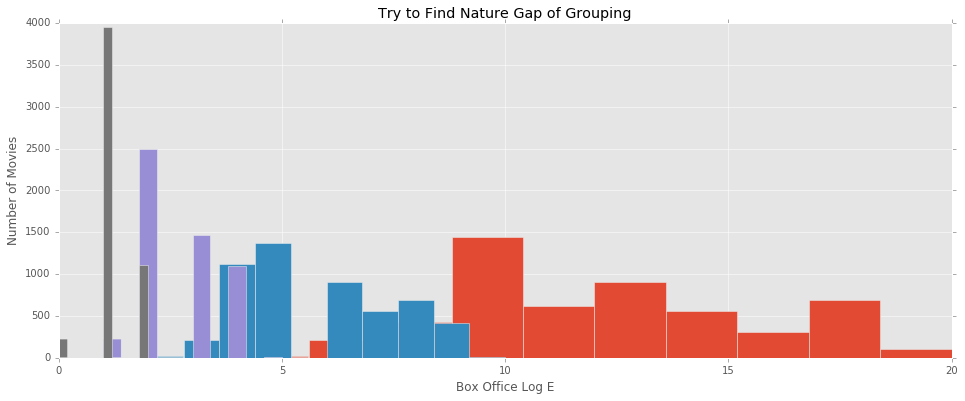

[  8.  15.  10. ...,  10.  17.   9.]


In [82]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 6)

box_office_log = np.trunc(np.log(box_office))
box_office_log_2 = np.trunc(np.log(box_office)/2)
box_office_log_4 = np.trunc(np.log(box_office)/4)
box_office_log_8 = np.trunc(np.log(box_office)/8)

plt.hist(box_office_log)
plt.hist(box_office_log_2)
plt.hist(box_office_log_4)
plt.hist(box_office_log_8)
plt.xlabel('Box Office Log E')
plt.ylabel('Number of Movies')
plt.title(r'Try to Find Nature Gap of Grouping')
plt.grid(True)
legend = plt.legend(loc='upper right', shadow=True)

plt.show()
print box_office_log

In [35]:
print max(box_office_log)
print max(box_office_log_2)
print max(box_office_log_4)
print max(box_office_log_8)

20.0
10.0
5.0
2.0


This conclusion can also be verified by the following machine learning session: 

We tried four different models for training:
1. Linear Regression
2. Logistic Regression
3. Artificial Neural Network
4. Gradient Boosting Classifier

By split the data into training (5000 samples) and testing (200 samples). For each method, the validation accuracy becomes higher when better classification label is chosen using method mentioned above. With the best method, we can achieve about 90% accuracy for box office prediction.

In [115]:
from sklearn import linear_model
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.layers.core import Activation, Dense
from sklearn.ensemble import GradientBoostingClassifier
import time

def linear(X, y, X_te):
    model = linear_model.LinearRegression()
    model.fit(X,y)
    return model.predict(X_te)

def logistic(X, y, X_te, c):
    model = linear_model.LogisticRegression(C=c)
    model.fit(X,y)
    return model.predict(X_te)

def ann(X, y, X_te):
    setY = set(y)
    type_num = max(setY)+1
    y_train = np.zeros([len(y),type_num])
    for i,item in enumerate(y):
        y_train[i][item] = 1
    model = Sequential()
    model.add(Dense(512, input_dim=479, init="uniform",activation="relu"))
    model.add(Dense(512, init="uniform", activation="sigmoid"))
    model.add(Dense(type_num))
    model.add(Activation("softmax"))  
    sgd = SGD(lr=0.003)
    model.compile(loss="binary_crossentropy", optimizer=sgd,metrics=["accuracy"])
    model.fit(X, y_train, nb_epoch=15, batch_size=5,verbose = 0)
    predictions = model.predict(X_te)
    # round predictions
    rounded = [np.argmax(item) for item in predictions]
    return rounded

def gbdt(X_tr, y_tr, X_eval, y_eval):
    params = {'n_estimators': 1200, 'max_depth': 3, 'subsample': 0.5,
              'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_tr, y_tr)
    acc = clf.score(X_eval, y_eval)
    return acc


print "=================LINEAR REGRESSION================"
start = time.time()
y_p = linear(feature_matrix1[:5000], box_office[:5000], feature_matrix1[-200:])
end = time.time()
print "Relative Estimate Error Ratio: {},in {} seconds".format(np.mean(np.abs(y_p-box_office[-200:])/y_p), end-start)
print 
print "======LOGISTIC REGRESSION CLASSIFICATION=========="

start = time.time()
y_p = logistic(feature_matrix[:5000], box_office_log[:5000], feature_matrix[-200:],50)
end = time.time()
print "Validation accuracy USING 20 GROUP: {} in {} seconds".format(np.mean(y_p==box_office_log[-200:]), end-start)

start = time.time()
y_p = logistic(feature_matrix[:5000], box_office_log_2[:5000], feature_matrix[-200:],2)
end = time.time()
print "Validation accuracy USING 10 GROUP: {} in {} seconds".format(np.mean(y_p==box_office_log_2[-200:]), end-start)

start = time.time()
y_p = logistic(feature_matrix[:5000], box_office_log_4[:5000], feature_matrix[-200:],50)
end = time.time()
print "Validation accuracy USING 5 GROUP: {} in {} seconds".format(np.mean(y_p==box_office_log_4[-200:]), end-start)

start = time.time()
y_p = logistic(feature_matrix[:5000], box_office_log_8[:5000], feature_matrix[-200:],100)
end = time.time()
print "Validation accuracy USING 3 GROUP: {} in {} seconds".format(np.mean(y_p==box_office_log_8[-200:]), end-start)
print 

print "=========ARTIFICIAL NEURAL NETWORK============="

start = time.time()
y_p = ann(feature_matrix[:5000], box_office_log[:5000], feature_matrix[-200:])
end = time.time()
print "Validation accuracy USING 20 GROUP: {} in {} seconds".format(np.mean(y_p==box_office_log[-200:]), end-start)

start = time.time()
y_p = ann(feature_matrix[:5000], box_office_log_2[:5000], feature_matrix[-200:])
end = time.time()
print "Validation accuracy USING 10 GROUP: {} in {} seconds".format(np.mean(y_p==box_office_log_2[-200:]), end-start)

start = time.time()
y_p = ann(feature_matrix[:5000], box_office_log_4[:5000], feature_matrix[-200:])
end = time.time()
print "Validation accuracy USING 5 GROUP: {} in {} seconds".format(np.mean(y_p==box_office_log_4[-200:]), end-start)

start = time.time()
y_p = ann(feature_matrix[:5000], box_office_log_8[:5000], feature_matrix[-200:])
end = time.time()
print "Validation accuracy USING 3 GROUP: {} in {} seconds".format(np.mean(y_p==box_office_log_8[-200:]), end-start)
print

print "========GradientBoostingClassifier============"
start = time.time()
acc = gbdt(feature_matrix[:5000], box_office_log[:5000], feature_matrix[-200:],box_office_log[-200:])
end = time.time()
print "Validation accuracy USING 20 GROUP: {} in {} seconds".format(acc, end-start)

start = time.time()
acc = gbdt(feature_matrix[:5000], box_office_log_2[:5000], feature_matrix[-200:],box_office_log_2[-200:])
end = time.time()
print "Validation accuracy USING 10 GROUP: {} in {} seconds".format(acc, end-start)

start = time.time()
acc = gbdt(feature_matrix[:5000], box_office_log_4[:5000], feature_matrix[-200:],box_office_log_4[-200:])
end = time.time()
print "Validation accuracy USING 5 GROUP: {} in {} seconds".format(acc, end-start)

start = time.time()
acc = gbdt(feature_matrix[:5000], box_office_log_8[:5000], feature_matrix[-200:],box_office_log_8[-200:])
end = time.time()
print "Validation accuracy USING 3 GROUP: {} in {} seconds".format(acc, end-start)


=================LINEAR REGRESSION================
Relative Estimate Error Ratio: 0.127022445872,in 0.323698997498 seconds

======LOGESTIC REGRESSION CLASSIFICATION==========
Validation accuracy USING 20 GROUP: 0.21 in 13.2697110176 seconds
Validation accuracy USING 10 GROUP: 0.355 in 3.26784896851 seconds
Validation accuracy USING 5 GROUP: 0.63 in 4.05537199974 seconds
Validation accuracy USING 3 GROUP: 0.85 in 3.1152009964 seconds

=========ARTIFICIAL NEURAL NETWORK=============


/Users/weijian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/weijian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Validation accuracy USING 20 GROUP: 0.155 in 43.8408131599 seconds
Validation accuracy USING 10 GROUP: 0.29 in 38.7547240257 seconds
Validation accuracy USING 5 GROUP: 0.51 in 38.357665062 seconds
Validation accuracy USING 3 GROUP: 0.795 in 37.7205359936 seconds

========GradientBoostingClassifier============
Validation accuracy USING 20 GROUP: 0.22 in 2654.17671299 seconds
Validation accuracy USING 10 GROUP: 0.42 in 1485.96691394 seconds
Validation accuracy USING 5 GROUP: 0.725 in 800.284039974 seconds
Validation accuracy USING 3 GROUP: 0.91 in 486.070210218 seconds


## 5. Conclusion
   During this project, we tried to discover the correlation between tweets and movie's box office. It turned out that this correlation does exist and can be used for movie industry or fans for marketing research and box office prediction. In the future, we want to dig into a more specific vertical movies' market, for example, to do geo-location based, audience wealth level based or movie type based research to give more precise results.


## 6. References
Asur, Sitaram, and Bernardo A. Huberman. "Predicting the future with social media." Web Intelligence and Intelligent Agent Technology (WI-IAT), 2010 IEEE/WIC/ACM International Conference on. Vol. 1. IEEE, 2010.

Bermingham, Adam, and Alan F. Smeaton. "On using Twitter to monitor political sentiment and predict election results." (2011).

Bollen, Johan, Huina Mao, and Xiaojun Zeng. "Twitter mood predicts the stock market." Journal of Computational Science 2.1 (2011): 1-8.

De Vries, Lisette, Sonja Gensler, and Peter SH Leeflang. "Popularity of brand posts on brand fan pages: An investigation of the effects of social media marketing." Journal of Interactive Marketing 26.2 (2012): 83-91.

Oghina, Andrei, et al. "Predicting imdb movie ratings using social media." European Conference on Information Retrieval. Springer Berlin Heidelberg, 2012.